In [75]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import warnings 
warnings.simplefilter('ignore')


### Загружаем данные 

In [162]:
sns.set(rc={'figure.figsize': (9,6)})

events_test = pd.read_csv('events_data_test.csv')
submissions_test = pd.read_csv('submission_data_test.csv')
events_train = pd.read_csv('event_data_train.csv')
submissions_train = pd.read_csv('submissions_data_train.csv')

events_data = pd.concat((events_train, events_test))
submissions_data = pd.concat((submissions_train, submissions_test)) 

events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [163]:
events_test.shape, events_train.shape

((274768, 4), (3480703, 4))

# Задача: по первым двум дням предсказать, пройдет ли юзер курс до конца

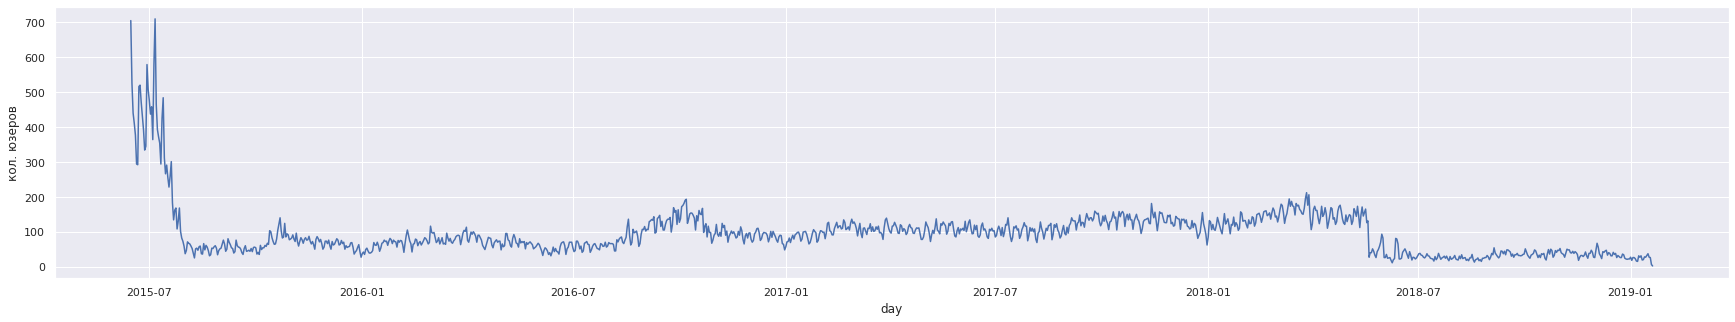

In [164]:
events_data['date'] = pd.to_datetime(events_data.timestamp , unit = 's')
events_data['day'] = events_data.date.dt.date

submissions_data['date'] = pd.to_datetime(submissions_data.timestamp , unit = 's')
submissions_data['day'] = submissions_data.date.dt.date
plt.figure(figsize=(30,5))
plt.ylabel('кол. юзеров')
events_data.groupby('day').user_id.nunique().plot()
plt.show()

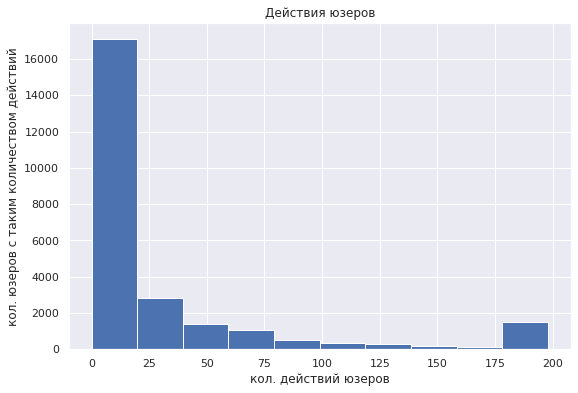

In [165]:
events_data.pivot_table(index='user_id' , 
                        columns='action' , 
                        values = 'step_id' , 
                        aggfunc = 'count' ,
                       fill_value=0).reset_index().discovered.hist()

plt.xlabel('кол. действий юзеров')
plt.ylabel('кол. юзеров с таким количеством действий')
plt.title('Действия юзеров')
plt.show()

## Будем считать что пользователь прошел курс если решил больше 40 практических заданий 

In [166]:
target = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count').fillna(0).reset_index()[['user_id', 'passed']]

target['passed'] = target['passed'].apply(lambda x: int(x > 40))
target.rename(columns={'passed':'is_pass_course'},inplace=True)
target['is_pass_course'].value_counts()

0    20412
1     5006
Name: is_pass_course, dtype: int64

In [167]:
def get_first_n_days(df, n):
    n = n * 24 * 60 * 60 # в секунды
    df['min_tmstmp'] = df.groupby('user_id').transform(np.min)['timestamp']
    mask = (df['timestamp'] - df['min_tmstmp']) <= n
    return df[mask].drop('min_tmstmp', axis=1)

# submissions_data = get_first_n_days(submissions_data, 2)
# events_data = get_first_n_days(events_data, 2)

In [168]:
users_scores= submissions_data.pivot_table(index='user_id' , 
                        columns='submission_status' , 
                        values = 'step_id' , 
                        aggfunc = 'count' ,
                       fill_value=0).reset_index()

users_events_data = events_data.pivot_table(index='user_id' , 
                        columns='action' , 
                        values = 'step_id' , 
                        aggfunc = 'count' ,
                       fill_value=0).reset_index()

In [169]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,12,1,0


In [170]:
# перерывы между действиями пользователей

gap_data = events_data[['user_id','timestamp']].groupby('user_id',as_index=False).agg(lambda x: list(x))
gap_data['mean_gap'] = gap_data['timestamp'].apply(np.diff).apply(np.mean).rename({'timestamp':'mean_gap'})/(60 * 60)
gap_data['max_gap'] = gap_data['timestamp'].apply(np.diff).apply(lambda x: max([0,*x])).rename({'timestamp':'max_gap'})/(60 * 60)
gap_data['min_gap'] = gap_data['timestamp'].apply(np.diff).apply(lambda x: min([1000000,*x])).rename({'timestamp':'min_gap'})/(60 * 60)

gap_data.drop('timestamp', axis=1, inplace=True)
gap_data

,user_id,mean_gap,max_gap,min_gap
0,1,0.000000,0.000000,0.000000
1,2,46.394655,1345.391944,0.000000
2,3,7.117176,1916.150833,0.000000
3,4,0.000000,0.000000,0.000000
4,5,253.026502,9361.892222,0.000000
...,...,...,...,...
25413,26796,0.000362,0.026389,-0.026389
25414,26797,12.825000,435.352222,0.000000
25415,26798,0.021776,0.601667,0.000000
25416,26799,0.002032,19.836389,-19.811667


In [171]:
users_data = gap_data.merge(users_scores , how='outer')
users_data = users_data.fillna(0)
users_data = users_data.merge(users_events_data , how='outer')

users_days = events_data.groupby('user_id')\
                        .day.nunique().to_frame().reset_index()

users_data = users_data.merge(users_days , how='outer')
users_data.head()


,user_id,mean_gap,max_gap,min_gap,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,0.000000,0.000000,0.0,0.0,0.0,1,0,0,1,1
1,2,46.394655,1345.391944,0.0,2.0,0.0,9,9,2,10,2
2,3,7.117176,1916.150833,0.0,29.0,23.0,91,87,30,192,7
3,4,0.000000,0.000000,0.0,0.0,0.0,1,1,0,1,1
4,5,253.026502,9361.892222,0.0,2.0,2.0,11,11,4,12,2


In [172]:


steps_tried = submissions_data.groupby('user_id')\
                                    .step_id.nunique().to_frame().reset_index()\
                                    .rename(columns={'step_id':'steps_tried'})

X = steps_tried.copy()

X = X.merge(submissions_data.pivot_table(index='user_id' , 
                        columns='submission_status' , 
                        values = 'step_id' , 
                        aggfunc = 'count' ,
                       fill_value=0).reset_index())

X['correct_ratio'] = X.correct / (X.correct + X.wrong)

X = X.merge(events_data.pivot_table(index='user_id' , 
                        columns='action' , 
                        values = 'step_id' , 
                        aggfunc = 'count' ,
                       fill_value=0).reset_index()[['user_id','viewed']],how='outer')

X = X.fillna(0)

X = X.merge(users_data, how='outer')


X = X.merge(target, how='left')
#X = X.drop('user_id' , axis=1)
X['is_pass_course'].value_counts()#финальные данные для работы

0    20412
1     5006
Name: is_pass_course, dtype: int64

In [182]:
Xs = X.drop(['is_pass_course','user_id'], axis=1)
y = X['is_pass_course']

X_train, X_test, y_train, y_test = train_test_split(Xs,y, shuffle=True)


In [183]:
forest = RandomForestClassifier(max_depth=8, min_samples_leaf=2, n_estimators=600).fit(X_train,y_train)

In [185]:
forest_score = forest.predict_proba(X_test)[:,1]

roc_auc_score(y_test, forest_score).round(3)

0.957


In [ ]:

outputs = pd.DataFrame()
outputs['user_id'] = X['user_id']
outputs['is_gone'] = forest.predict_proba(Xs)[:,1]
outputs.to_csv('course_outflow', index=False)